# Exploring CNNs

In this assignment, you will modify a baseline CNN architecture and explore different regularization an optimization schemes.

We start by ensuring that we are using a GPU if available. If you are using Google Colab, make sure you change the Notebook Setting so a GPU is useed for Hardware Acceleration.

In [ ]:
import torch
import numpy as np

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using CPU


## Loading the Data

We load the data, transform it to be the in the correct format, and create the training, validation and test sets.


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Size of the batch
batch_size = 20
# Percentage of training used for validation
valid_size = 0.2

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    # Converting RGB [0,255] to Tensor [0,1]
    transforms.ToTensor(),
    # Normalizes using specified mean and std per channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

# Selecting the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Getting training indices that will be used for validation
num_train = len(train_data)
idx = list(range(num_train))
np.random.shuffle(idx)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = idx[split:], idx[:split]

# Defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Preparing data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Defining the Model and Optimizer

A class is created to specify the network structure.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Defining the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.001)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training the Model

We define a helper function to make it easier test different models, criterions or optimizers. The best model trained is stored locally.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.302612 	Validation Loss: 2.301668
Validation loss decreased (inf --> 2.301668).  Saving model ...
Epoch: 2 	Training Loss: 2.300159 	Validation Loss: 2.298428
Validation loss decreased (2.301668 --> 2.298428).  Saving model ...
Epoch: 3 	Training Loss: 2.295352 	Validation Loss: 2.290991
Validation loss decreased (2.298428 --> 2.290991).  Saving model ...
Epoch: 4 	Training Loss: 2.282270 	Validation Loss: 2.266120
Validation loss decreased (2.290991 --> 2.266120).  Saving model ...
Epoch: 5 	Training Loss: 2.238237 	Validation Loss: 2.202193
Validation loss decreased (2.266120 --> 2.202193).  Saving model ...
Epoch: 6 	Training Loss: 2.175705 	Validation Loss: 2.141901
Validation loss decreased (2.202193 --> 2.141901).  Saving model ...
Epoch: 7 	Training Loss: 2.117992 	Validation Loss: 2.078617
Validation loss decreased (2.141901 --> 2.078617).  Saving model ...
Epoch: 8 	Training Loss: 2.037280 	Validation Loss: 1.990176
Validation loss decreased (2.07861

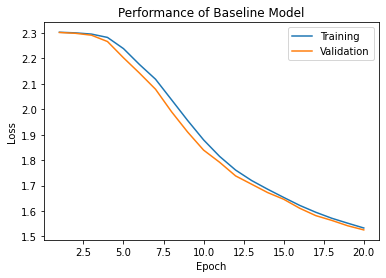

In [5]:
import matplotlib.pyplot as plt

# Specifying the number of epochs
n_epochs = 20

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):
  # Unpacking the number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ######################
      # Training the model #
      ######################
      model.train()
      for data, target in train_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data)
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      ########################    
      # Validating the model #
      ########################
      model.eval()
      for data, target in valid_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/len(train_sampler)
      valid_loss = valid_loss/len(valid_sampler)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist

# Executing the training
epochs_list, train_losslist, valid_losslist = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model_cifar.pt'))

# Plotting the learning curves
plt.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

## Evaluating Performance

Here we use the test set for the final performance of the model. We define a helper function as well for ease of future evaluation of different models.


In [6]:
def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in test_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  return

# Executing the assessment
assessNet(model,criterion)

Test Loss: 1.521844

Test Accuracy of   airplane: 47% (479/1000)
Test Accuracy of automobile: 59% (592/1000)
Test Accuracy of       bird: 26% (261/1000)
Test Accuracy of        cat: 18% (185/1000)
Test Accuracy of       deer: 28% (281/1000)
Test Accuracy of        dog: 41% (414/1000)
Test Accuracy of       frog: 65% (655/1000)
Test Accuracy of      horse: 57% (577/1000)
Test Accuracy of       ship: 48% (482/1000)
Test Accuracy of      truck: 53% (539/1000)

Test Accuracy (Overall): 44% (4465/10000)


## **[Task 1] Comparing Optimizers** [50 pts]

The goal of of this section is to compare the performance of various optimizers: SGD with momentum, RMS Prop and Adam. Make sure you complete the following steps:

1. [10 pts] Train the network with SGD with momentum and perform the assessment
2. [10 pts] Train the network with RMS Prop and perform the assessment
3. [10 pts] Train the network with Adam and perform the assessment
4. [10 pts] Create a plot comparing training loss and another for validation loss for all the methods including your baseline
5. [10 pts] Comment on the performance of each optimizer. Which one had the steepest learning curve? Which one gave the final best performance in the validation and test sets? 

In [7]:
# ADD - Training a new model with SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=.001,momentum= 0.9,dampening=0, weight_decay=0, nesterov=False)
SGD_epochs_list, SGD_train_list, SGD_valid_list = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)
#model training
model.load_state_dict(torch.load('model_cifar.pt'))
#Passing the results to assessNet for evaluation
assessNet(model,criterion)

Epoch: 1 	Training Loss: 1.536840 	Validation Loss: 1.477513
Validation loss decreased (inf --> 1.477513).  Saving model ...
Epoch: 2 	Training Loss: 1.430204 	Validation Loss: 1.383784
Validation loss decreased (1.477513 --> 1.383784).  Saving model ...
Epoch: 3 	Training Loss: 1.337958 	Validation Loss: 1.313667
Validation loss decreased (1.383784 --> 1.313667).  Saving model ...
Epoch: 4 	Training Loss: 1.264602 	Validation Loss: 1.242848
Validation loss decreased (1.313667 --> 1.242848).  Saving model ...
Epoch: 5 	Training Loss: 1.199623 	Validation Loss: 1.223173
Validation loss decreased (1.242848 --> 1.223173).  Saving model ...
Epoch: 6 	Training Loss: 1.144431 	Validation Loss: 1.184544
Validation loss decreased (1.223173 --> 1.184544).  Saving model ...
Epoch: 7 	Training Loss: 1.095594 	Validation Loss: 1.149597
Validation loss decreased (1.184544 --> 1.149597).  Saving model ...
Epoch: 8 	Training Loss: 1.053736 	Validation Loss: 1.142786
Validation loss decreased (1.14959

In [8]:
# ADD - Training a new model with RMS Prop
optimizer = optim.RMSprop(model.parameters(), lr=0.001,alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
RMSprop_epochs_list, RMSprop_train_list, RMSprop_valid_list = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)
model.load_state_dict(torch.load('model_cifar.pt'))
assessNet(model,criterion)

Epoch: 1 	Training Loss: 1.071792 	Validation Loss: 1.082192
Validation loss decreased (inf --> 1.082192).  Saving model ...
Epoch: 2 	Training Loss: 0.952628 	Validation Loss: 1.099181
Epoch: 3 	Training Loss: 0.881065 	Validation Loss: 1.081883
Validation loss decreased (1.082192 --> 1.081883).  Saving model ...
Epoch: 4 	Training Loss: 0.819122 	Validation Loss: 1.061807
Validation loss decreased (1.081883 --> 1.061807).  Saving model ...
Epoch: 5 	Training Loss: 0.764412 	Validation Loss: 1.104797
Epoch: 6 	Training Loss: 0.718688 	Validation Loss: 1.103282
Epoch: 7 	Training Loss: 0.671738 	Validation Loss: 1.169058
Epoch: 8 	Training Loss: 0.634562 	Validation Loss: 1.195850
Epoch: 9 	Training Loss: 0.595119 	Validation Loss: 1.247120
Epoch: 10 	Training Loss: 0.560071 	Validation Loss: 1.291569
Epoch: 11 	Training Loss: 0.531943 	Validation Loss: 1.401531
Epoch: 12 	Training Loss: 0.499508 	Validation Loss: 1.411823
Epoch: 13 	Training Loss: 0.474730 	Validation Loss: 1.457062
E

In [9]:
# ADD - Training a new model with Adam
optimizer = optim.Adam(model.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
ADAM_epochs_list, ADAM_train_list, ADAM_valid_list = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)
model.load_state_dict(torch.load('model_cifar.pt'))
assessNet(model,criterion)

Epoch: 1 	Training Loss: 0.761127 	Validation Loss: 1.073198
Validation loss decreased (inf --> 1.073198).  Saving model ...
Epoch: 2 	Training Loss: 0.709932 	Validation Loss: 1.168457
Epoch: 3 	Training Loss: 0.662310 	Validation Loss: 1.152190
Epoch: 4 	Training Loss: 0.624777 	Validation Loss: 1.164972
Epoch: 5 	Training Loss: 0.589891 	Validation Loss: 1.253026
Epoch: 6 	Training Loss: 0.551787 	Validation Loss: 1.264053
Epoch: 7 	Training Loss: 0.516714 	Validation Loss: 1.347697
Epoch: 8 	Training Loss: 0.486827 	Validation Loss: 1.395939
Epoch: 9 	Training Loss: 0.461086 	Validation Loss: 1.439030
Epoch: 10 	Training Loss: 0.432161 	Validation Loss: 1.508059
Epoch: 11 	Training Loss: 0.408950 	Validation Loss: 1.561832
Epoch: 12 	Training Loss: 0.387370 	Validation Loss: 1.675387
Epoch: 13 	Training Loss: 0.364561 	Validation Loss: 1.689088
Epoch: 14 	Training Loss: 0.354756 	Validation Loss: 1.762668
Epoch: 15 	Training Loss: 0.336027 	Validation Loss: 1.940989
Epoch: 16 	Trai

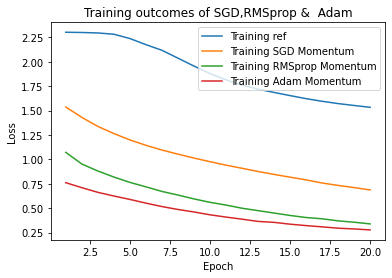

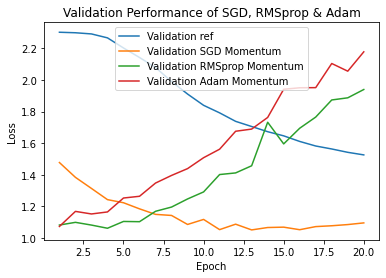

In [10]:
# ADD - Plots Comparing training and validation loss
plt.plot(epochs_list, train_losslist, SGD_epochs_list, SGD_train_list,
  RMSprop_epochs_list, RMSprop_train_list, ADAM_epochs_list,
  ADAM_train_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training ref','Training SGD Momentum',
            'Training RMSprop Momentum','Training Adam Momentum'])
plt.title("Training outcomes of SGD,RMSprop &  Adam")
plt.show()

plt.plot(epochs_list, valid_losslist, SGD_epochs_list, SGD_valid_list,
  RMSprop_epochs_list, RMSprop_valid_list, ADAM_epochs_list,
  ADAM_valid_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Validation ref', 'Validation SGD Momentum',
            'Validation RMSprop Momentum','Validation Adam Momentum'])
plt.title("Validation Performance of SGD, RMSprop & Adam")
plt.show()

ADD - Comments

1) The curve for learning rate for SGD with momentum is steeper & stable when compared to RMS prop and Adam.

2)  By comparing the training loss and validation loss since the SGD optimizer has a smoother decreasing curve for validation loss, it is the most preferable optimizer even though both RMSprop & Adam have a better accuracy.

3) Therefore, SGD with momentum is considered as the best optimizer for this model with an accuracy equal to ~63.4%

## **[Task 2] Applying Standard Regularization** [50 pts]

The goal of this section is to compare the effect of different normalization approaches including Batch normalization and Dropout. Make sure to complete the following steps:

1. [15 pts] Create a new model by adding a batch normalization layer after each convolutional layer and between the dense layers of the base model. Train it using the Adam optimizer and perform the assessment.
2. [15 pts] Create a new model by adding dropout after each convolutional layer and between the dense layers of the base model with a dropout rate equal to $0.1$. Train it using the Adam optimizer and perform the assessment.
3. [10 pts] Create a plot comparing training loss and another for validation loss for the batch normalization and dropout versions against the base model trained with the Adam optimizer.
4. [10 pts] Comment on the performance of each model. Which one had the steepest learning curve? Which one gave the final best performance in the validation and test sets? 

In [12]:
# ADD - CNN architecture with batch normalization
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv1_bn = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.conv2_bn = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.bn3 = nn.BatchNorm1d(120)
    self.fc2 = nn.Linear(120, 84)
    self.bn4 = nn.BatchNorm1d(84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
    x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
    x = x.view(-1, 16 * 5 * 5) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.bn3(self.fc1(x)))
    x = F.relu(self.bn4(self.fc2(x)))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
ADAM_epochs_list, ADAM_train_list, ADAM_valid_list = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)
model.load_state_dict(torch.load('model_cifar.pt'))
assessNet(model,criterion)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch: 1 	Training Loss: 1.484081 	Validation Loss: 1.227120
Validation loss decreased (inf --> 1.227120).  Saving model ...
Epoch: 2 	Training Loss: 1.224182 	Validation Loss: 1.145288
Validation loss decreased (1.227120 --> 1.145288).  Sa

In [13]:
# ADD - CNN architecture with dropout
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv1_do = nn.Dropout2d(0.1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.conv2_do = nn.Dropout2d(0.1)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.do1 = nn.Dropout(0.1)
    self.fc2 = nn.Linear(120, 84)
    self.do2 = nn.Dropout(0.1)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1_do(self.conv1(x))))
    x = self.pool(F.relu(self.conv2_do(self.conv2(x))))
    x = x.view(-1, 16 * 5 * 5) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.do1(self.fc1(x)))
    x = F.relu(self.do2(self.fc2(x)))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
ADAM1_epochs_list, ADAM1_train_list, ADAM1_valid_list = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)
model.load_state_dict(torch.load('model_cifar.pt'))
assessNet(model,criterion)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_do): Dropout2d(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_do): Dropout2d(p=0.1, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (do1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (do2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch: 1 	Training Loss: 1.736257 	Validation Loss: 1.455826
Validation loss decreased (inf --> 1.455826).  Saving model ...
Epoch: 2 	Training Loss: 1.505163 	Validation Loss: 1.355307
Validation loss decreased (1.455826 --> 1.355307).  Saving model ...
Epoch: 3 	Training Loss: 1.420487 	Validation Loss: 1.297388
Validation loss decreased (1.355307 --> 1.297388).  Saving model ...
Epoch: 4 	Training Loss: 1.363569 	Validation Loss:

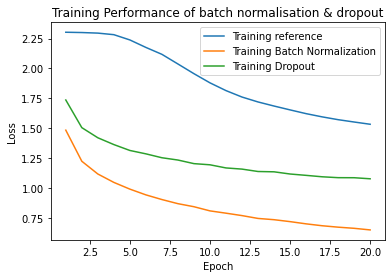

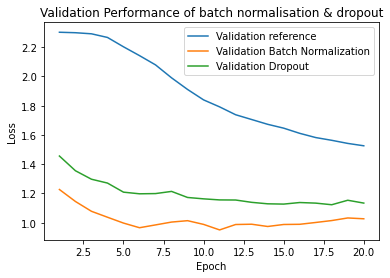

In [14]:
# ADD - Plots Comparing training and validation loss
plt.plot(epochs_list, train_losslist, ADAM_epochs_list, ADAM_train_list,
  ADAM1_epochs_list, ADAM1_train_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training reference','Training Batch Normalization',
            'Training Dropout'])
plt.title("Training Performance of batch normalisation & dropout")
plt.show()

plt.plot(epochs_list, valid_losslist, ADAM_epochs_list, ADAM_valid_list,
  ADAM1_epochs_list, ADAM1_valid_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Validation reference', 'Validation Batch Normalization',
            'Validation Dropout'])
plt.title("Validation Performance of batch normalisation & dropout")
plt.show()

ADD - Comments

1) It can be observed that batch normalization with Adam has the steepest curve with a maximum most accuracy of ~66.83%.

2) Validation loss curve for dropout is smooth as compared to that for batch normalization.

3) Model with batch normalization gives the best performance as the accuracy for validation set is higher for batch normalization as
compared to dropout.